In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
from skimage import io as im
from skimage import color
import torch

In [451]:
img_path = "Input/Images/rue_cremieux_small.jpg"
mask_path =  "Input/Inpainting/Masks/rue_cremieux_small_mask.jpg"

In [452]:
def norm(x):
    out = (x -0.5) *2
    return out.clamp(-1, 1)

def np2torch(x):
    #if opt.nc_im == 3:
    x = x[:, :, :, None]
    x = x.transpose((3, 2, 0, 1))/255
    
    """
    else:
    x = color.rgb2gray(x)
    x = x[:,:,None,None]
    x = x.transpose(3, 2, 0, 1)
    """
 
    x = torch.from_numpy(x)
    x =  x.type(torch.FloatTensor)
    #x = x.type(torch.FloatTensor)
    x = norm(x)
    return x

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def convert_image_np(inp):
    if inp.shape[1]==3:
        inp = denorm(inp)
        inp = move_to_cpu(inp[-1,:,:,:])
        inp = inp.numpy().transpose((1,2,0))
    else:
        inp = denorm(inp)
        inp = move_to_cpu(inp[-1,-1,:,:])
        inp = inp.numpy().transpose((0,1))
        # mean = np.array([x/255.0 for x in [125.3,123.0,113.9]])
        # std = np.array([x/255.0 for x in [63.0,62.1,66.7]])

    inp = np.clip(inp,0,1)
    return inp

def move_to_cpu(t):
    t = t.to(torch.device('cpu'))
    return t

def torch2uint8(x):
    x = x[0,:,:,:]
    x = x.permute((1,2,0))
    x = 255*denorm(x)
    x = x.cpu().numpy()
    x = x.astype(np.uint8)
    return x


In [453]:
def imresize_in(im, scale_factor=None, output_shape=None, kernel=None, antialiasing=True, kernel_shift_flag=False):
    # First standardize values and fill missing arguments (if needed) by deriving scale from output shape or vice versa
    scale_factor, output_shape = fix_scale_and_size(im.shape, output_shape, scale_factor)

    # For a given numeric kernel case, just do convolution and sub-sampling (downscaling only)
    if type(kernel) == np.ndarray and scale_factor[0] <= 1:
        return numeric_kernel(im, kernel, scale_factor, output_shape, kernel_shift_flag)

    # Choose interpolation method, each method has the matching kernel size
    method, kernel_width = {
        "cubic": (cubic, 4.0),
        "lanczos2": (lanczos2, 4.0),
        "lanczos3": (lanczos3, 6.0),
        "box": (box, 1.0),
        "linear": (linear, 2.0),
        None: (cubic, 4.0)  # set default interpolation method as cubic
    }.get(kernel)

    # Antialiasing is only used when downscaling
    antialiasing *= (scale_factor[0] < 1)

    # Sort indices of dimensions according to scale of each dimension. since we are going dim by dim this is efficient
    sorted_dims = np.argsort(np.array(scale_factor)).tolist()

    # Iterate over dimensions to calculate local weights for resizing and resize each time in one direction
    out_im = np.copy(im)
    for dim in sorted_dims:
        # No point doing calculations for scale-factor 1. nothing will happen anyway
        if scale_factor[dim] == 1.0:
            continue

        # for each coordinate (along 1 dim), calculate which coordinates in the input image affect its result and the
        # weights that multiply the values there to get its result.
        weights, field_of_view = contributions(im.shape[dim], output_shape[dim], scale_factor[dim],
                                               method, kernel_width, antialiasing)

        # Use the affecting position values and the set of weights to calculate the result of resizing along this 1 dim
        out_im = resize_along_dim(out_im, dim, weights, field_of_view)

    return out_im

In [454]:
img = im.imread(img_path)
img = np2torch(img)
img = img[:, 0:3, :, :]
mask = im.imread(mask_path)
mask = np2torch(mask)
mask = denorm(mask)

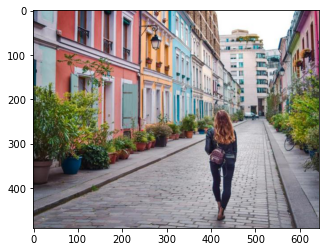

In [455]:
plt.imshow(convert_image_np(img))

tensor([[1., 1., 1.]])


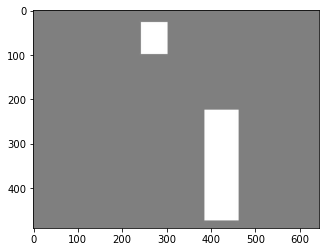

In [456]:
plt.imshow(convert_image_np(mask))
print(denorm(mask)[:,:,350, 450])

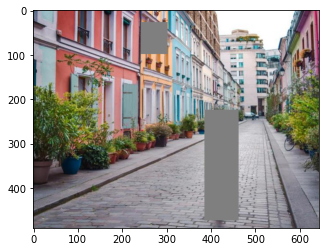

In [457]:
occluded = img * (1 - mask)
plt.imshow(convert_image_np(occluded))

In [458]:
print(mask.shape)

torch.Size([1, 3, 490, 644])


In [459]:
rect1 = [int(386.19736842105266), int(224.112), int(463.565789473684), int(473.98400000000004)]
rect2 = [int(243.71052631578948), int(27.048000000000002), int(303.0263157894737), int(99.82000000000001)]

#occlusions = [rect1, rect2]
occlusions = [rect1]

In [460]:
print(img[0,0, :,:].shape)

torch.Size([490, 644])


In [461]:
def get_patch_average(patch, patch_radius):
    s = 0
    for i in range(patch.shape[0]):
        for j in range(patch.shape[1]):
            s += patch[i, j]
    return float(s) / (2 * patch_radius + 1) ** 2


def get_patch_standard_deviation(patch, patch_radius):
    s = 0
    avg = get_patch_average(patch, patch_radius)
    for i in range(patch.shape[0]):
        for j in range(patch.shape[1]):
            s += (patch[i][j] - avg) ** 2
    return (s ** 0.5) / (2 * patch_radius + 1)


def zncc(patch1, patch2, patch_radius):
    std1 = get_patch_standard_deviation(patch1, patch_radius)
    std2 = get_patch_standard_deviation(patch2, patch_radius)
    avg1 = get_patch_average(patch1, patch_radius)
    avg2 = get_patch_average(patch2, patch_radius)
    
    #print(avg1, avg2, std1, std2)
  
    
    s = 0
    for i in range(2 * patch_radius):
        for j in range(2 * patch_radius):
            s += (patch1[i, j] - avg1) * (patch2[i,j] - avg2)
    return float(s) / ((2 * patch_radius + 1) ** 2 * std1 * std2)


def patch_distance(patch1, patch2, patch_radius):
  
    s=0
    for k in range(3):
        #print(patch1[0, k, :, :].shape)
        #print(patch1.shape)
        s+= zncc(patch1[0,k, :, :], patch2[0,k, :, :], patch_radius)
    # mean along channels
    s/=3
    return s   

In [462]:
def is_valid(j_center, i_center, patch_radius, img):
    
    
    # pixel is part of the image
    if not patch_radius < i_center < img.shape[2] - patch_radius or not patch_radius < j_center < img.shape[3] - patch_radius: 
      
        return False
    
    # pixel is not partially or totally occluded
    for i in range(i_center - patch_radius, i_center + patch_radius):
      
        for j in range(j_center - patch_radius, j_center + patch_radius):     
            if mask[0,0,i, j]==1:
               
                return False

    return True

In [513]:
def best_match(neighborhood_radius, patch_radius, x, y, ref_patch, patch_mask, img):
    ref_patch_valid = ref_patch * (1 - patch_mask)
    
    
    best_dist = float("inf")
    nearest_neighbor = None
    
    #for k in range(y-neighborhood_radius, y+neighborhood_radius):
    #    for l in range(x-neighborhood_radius, x + neighborhood_radius):
    #       img[0, :, k, l] = torch.Tensor([1, 0, 0])
    
    #plt.imshow(convert_image_np(img))
    #plt.show()
    
    for i in range(y - neighborhood_radius, y + neighborhood_radius):
        for j in range(x - neighborhood_radius, x + neighborhood_radius):
            if is_valid(j, i, patch_radius, img):
               
                
                current_patch = img[:, :, i-patch_radius:i+patch_radius, j-patch_radius: j+patch_radius]
              
                
                current_patch_valid = current_patch * (1 - patch_mask)
                
                """print("ref")
                plt.imshow(convert_image_np(ref_patch_valid))
                plt.show()

                print("current")
                plt.imshow(convert_image_np(current_patch_valid))
                plt.show()"""
                
                
                
    
                dist = patch_distance(ref_patch_valid, current_patch_valid, patch_radius)
                if dist < best_dist:
                    best_dist = dist
                    nearest_neighbor = [j, i]
              
    
    assert nearest_neighbor is not None, "no neighbor found"
    return nearest_neighbor
                
                
    

In [540]:
def fill_border(occlusions, img, patch_radius=5, neighborhood_radius=10, offset=5):
    for occlusion in occlusions:
        x1, y1, x2, y2 = occlusion
   
        if x1 + offset == x2 or y1 + offset == y2:
            print("end")
            
        else:
            
            
              # upper row
            for j in range(x2, x1, -patch_radius):
                print(y1, j)

                ref_patch = img[:, :, y1 - 2*patch_radius + offset: y1 + offset, j-patch_radius:j+patch_radius]
               
            
                #plt.imshow(convert_image_np( img[:, :, y1 - 2*patch_radius + offset: y1 + offset, j-patch_radius:j+patch_radius]))
                #plt.show()

                patch_mask = mask[:, :, y1 - 2*patch_radius + offset: y1 + offset, j-patch_radius:j+patch_radius]

                ref_patch_valid = ref_patch * (1 - patch_mask)

                j_NN, i_NN = best_match(neighborhood_radius, patch_radius, j, y1, ref_patch, patch_mask, img)

                NN_patch = img[:, :, i_NN-patch_radius:i_NN+patch_radius, j_NN-patch_radius: j_NN+patch_radius]

                valid_NN_patch = NN_patch * (patch_mask)
                
                print("sum")
                plt.imshow(convert_image_np(ref_patch_valid + valid_NN_patch))
                plt.show()
                img[0, :, y1 - 2*patch_radius + offset: y1 + offset, j-patch_radius:j+patch_radius] = ref_patch_valid + valid_NN_patch
                
               
                
                plt.imshow(convert_image_np(img))
                plt.show()
            print("upper row done")
            
            
             # lower row
            for j in range(x1, x2, patch_radius):
                
                

                ref_patch = img[:, :, y2-offset: y2 + 2*patch_radius - offset, j-patch_radius:j+patch_radius]

                patch_mask = mask[:, :, y2-offset: y2 + 2*patch_radius - offset, j-patch_radius:j+patch_radius]


                ref_patch_valid = ref_patch * (1 - patch_mask)

                j_NN, i_NN = best_match(neighborhood_radius, patch_radius, j, y2, ref_patch, patch_mask, img)

                NN_patch = img[:, :, i_NN-patch_radius:i_NN+patch_radius, j_NN-patch_radius: j_NN+patch_radius]

                valid_NN_patch = NN_patch * (patch_mask)
                img[0, :, y2-offset: y2 + 2*patch_radius - offset, j-patch_radius:j+patch_radius] = ref_patch_valid + valid_NN_patch

                plt.imshow(convert_image_np(img))
                plt.show()
            print("lower row done")
            
            # left column
            for i in range(y1, y2, patch_radius):
                
                #plt.imshow(convert_image_np(img[:, :, y2-offset: y2 + 2*patch_radius - offset, j-patch_radius:j+patch_radius]))
              
                #plt.show()
                                                                                                                 
                ref_patch = img[:, :, i-patch_radius:i+patch_radius, x1-2*patch_radius + offset: x1 + offset]
                patch_mask = mask[:, :, i-patch_radius:i+patch_radius, x1-2*patch_radius+ offset : x1 + offset]

                ref_patch_valid = ref_patch * (1 - patch_mask)

                j_NN, i_NN = best_match(neighborhood_radius, patch_radius, x1, i, ref_patch, patch_mask, img)

                NN_patch = img[:, :, i_NN-patch_radius:i_NN+patch_radius, j_NN-patch_radius: j_NN+patch_radius]

                valid_NN_patch = NN_patch * (patch_mask)
                img[0, :, i-patch_radius:i+patch_radius, x1-2*patch_radius + offset: x1 + offset] = ref_patch_valid + valid_NN_patch

                plt.imshow(convert_image_np(img))
                plt.show()
            print("left column done")

                                                                                                                 
           
            
            
         
         

            # right column
            for i in range(y2, y1, - patch_radius):

                ref_patch = img[:, :, i-patch_radius:i+patch_radius, x2 - offset : x2 +2*patch_radius - offset:]
                patch_mask = mask[:, :, i-patch_radius:i+patch_radius, x2 - offset : x2 +2*patch_radius - offset:]

                ref_patch_valid = ref_patch * (1 - patch_mask)

                j_NN, i_NN = best_match(neighborhood_radius, patch_radius, x2, i, ref_patch, patch_mask, img)

                NN_patch = img[:, :, i_NN-patch_radius:i_NN+patch_radius, j_NN-patch_radius: j_NN+patch_radius]

                valid_NN_patch = NN_patch * (patch_mask)
                img[0, :, i-patch_radius:i+patch_radius, x1 - offset : x1 +2*patch_radius - offset:] = ref_patch_valid + valid_NN_patch

                plt.imshow(convert_image_np(img))
                plt.show()
            print("right column done")

          

            plt.imshow(convert_image_np(img))
            plt.show()
            
            x1_new, y1_new, x2_new, y2_new = x1 + offset, y1 + offset, x2 - offset, y2 - offset
            occlusions = [[x1_new, y1_new, x2_new, y2_new]]
            fill_border(occlusions, img, patch_radius=10, neighborhood_radius=50, offset=3)
           
                
        
"""print("NN")
plt.imshow(convert_image_np(NN_patch))
plt.show()

print("NN fill")
plt.imshow(convert_image_np(valid_NN_patch))
plt.show()

print("ref")
plt.imshow(convert_image_np(ref_patch_valid))
plt.show()

print("sum")
plt.imshow(convert_image_np(ref_patch_valid + valid_NN_patch))
plt.show()"""


#print(valid_patch.shape)
#valid_patch = valid_patch.permute(1, 2, 0)
#print(valid_patch.shape)
#print(patch.shape)

#plt.imshow(convert_image_np(img[:, :, 200:300,350:410]))
#plt.show()

#valid_patch = img[0, :, i-patch_radius:i+patch_radius, int(x1)-patch_radius: int(x1)]

#for k in range(patch.shape[0]):
#    for l in range(patch.shape[1]):
#        img[0, :, k, l] = torch.Tensor([1, 0, 0])
"""for k in range(i-patch_radius, i+patch_radius):
for l in range(int(x1)-patch_radius, int(x1)):
    occluded[0, :, k, l] = torch.Tensor([1, 0, 0])""";

#plt.imshow(convert_image_np(occluded[:, :, :, :]));
         
            
    

224 463
sum


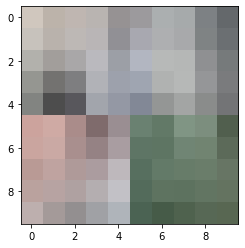

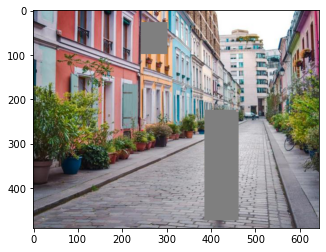

224 458
sum


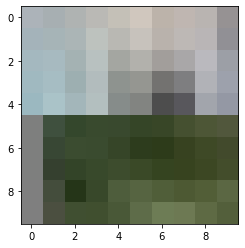

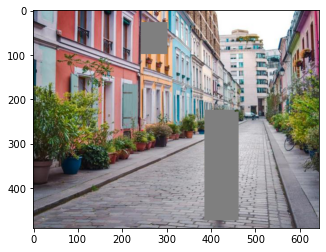

224 453
sum


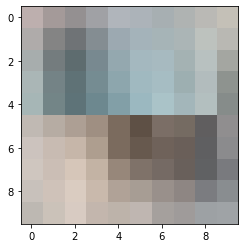

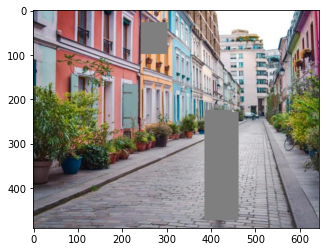

224 448
sum


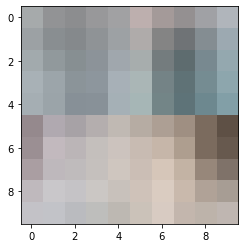

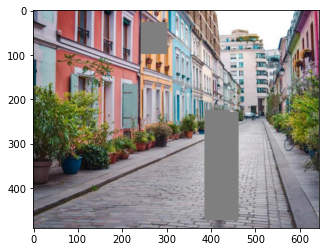

224 443


KeyboardInterrupt: 

In [541]:
fill_border(occlusions.copy(), occluded.clone())

In [382]:
for i in range(20, 10, -2):
    print(i)

20
18
16
14
12
